In [1]:
import sys
sys.path.append('../..')

import eeg_decoder
import numpy as np
from collections import OrderedDict
%load_ext autoreload
%autoreload 2

In [2]:
experiment_name = 'C01'
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1000])

In [3]:
time_window = 25 
time_step = 25
trial_bin_size = 20
n_splits = 1000
group_dict = OrderedDict([('1',[11]),('1 (hashtag)',[12]),('1 (letter)',[13]),('Set size 2',[20])])
train_labels = ['1','Set size 2']
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict,train_labels=train_labels)
clfr = eeg_decoder.Classification(wrangl,exp.nsub)

In [4]:
for isub in range(exp.nsub):

    print(isub)
    xdata,ydata = exp.load_eeg(isub)
    xdata,ydata = wrangl.group_labels(xdata,ydata)

    for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata):

        X_train_all, y_train = wrangl.select_training_data(X_train_all, y_train) 
        X_train_all, y_train = wrangl.balance_labels(X_train_all, y_train)
        y_test_shuffle = np.random.permutation(y_test)

        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):

            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

interp = eeg_decoder.Interpreter(clfr, subtitle='1v2_all')
interp.save_results(timestamp=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [4]:
interp = eeg_decoder.Interpreter()
interp.load_results('1v2_all')

C:\Users\William\AppData\Roaming\Python\Python38\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\William\AppData\Roaming\Python\Python38\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


1
Significant timepoints: [136 160 232 256 280 304 328 352 376 400 424 448 472 496 520 544 568 592
 616 640 664 688 712 736 760 784 808 832 856 880 904 928 952 976]
2
Significant timepoints: [184 256 304 328 352 376 400 424 448 472 496 520 544 568 592 616 640 688
 712 760 784 808 832 880 904 928 952 976]


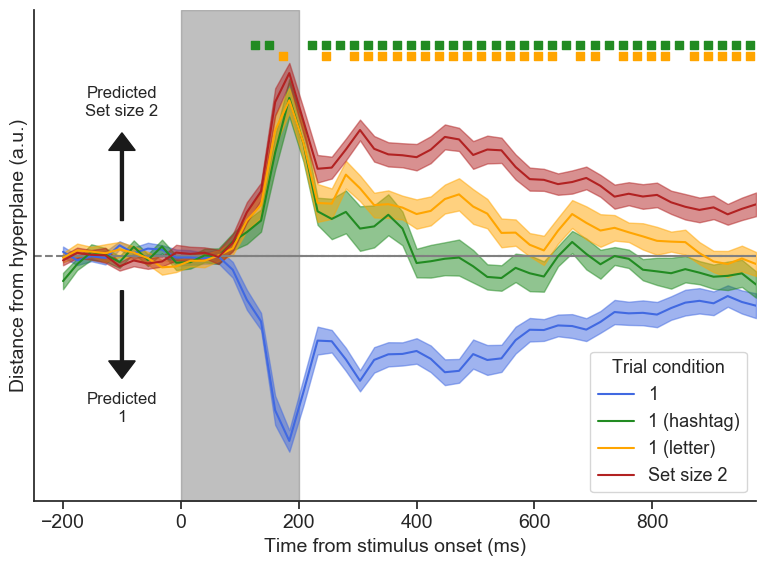

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.close()

sns.set_theme(font_scale=1.5,style='white')
plt.subplots(figsize=(8,6))
interp.colors = ['royalblue', 'forestgreen', 'orange','firebrick']
interp.plot_hyperplane(
    significance_testing_pair=[(1,3),(2,3)],sig_y=3, stim_time=[0,200],
    ylim=[-3.5,3.5],stim_label_xy=[130,3.1],label_text_x=-100,label_text_ys=[-1.95,1.95],arrow_ys=[-.5,.5],
    savefig=False,subtitle='_11h1l1_conf_from_2')

0
Significant timepoints: [112 136 160 184 208 232 256 280 304 328 352 376 400 424 448 472 496 520
 544 568 592 616 640 664 688 712 736 760 784 808 832 856 880 904 928 952
 976]
1
Significant timepoints: [136 160 232 256 280 304 328 352 376 400 424 448 472 496 520 544 568 592
 616 640 664 688 712 736 760 784 808 832 856 880 904 928 952 976]
2
Significant timepoints: [184 256 304 328 352 376 400 424 448 472 496 520 544 568 592 616 640 688
 712 760 784 808 832 880 904 928 952 976]


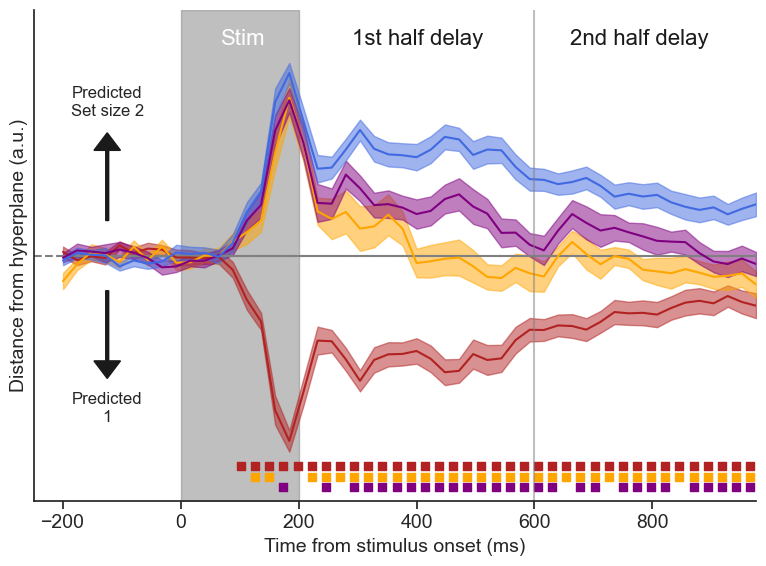

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.close()

sns.set_theme(font_scale=1.5,style='white')
plt.subplots(figsize=(8,6))

interp.colors = ['firebrick', 'orange','purple','royalblue']
interp.plot_hyperplane(
    stim_time=[0,200], 
    significance_testing_pair=[(0,3),(1,3),(2,3)],
    sig_y=-3,
    test_from_zero=False,
    ylim=[-3.5,3.5],stim_label_xy=[120,3.1],
    label_text_ys=[-1.95,1.95],label_text_x=-125,
    arrow_ys=[-.5,.5],add_delay_labels=True,
    savefig=False,subtitle='1v2new',legend_pos=None)

# break it up into time windows

In [6]:
import numpy as np
import pandas as pd
def get_condition_means(conf_scores, time_idx=None):

    if time_idx is None:
        delay_acc =np.mean(np.mean(interp.confidence_scores,2),1)
    else:
        delay_acc =np.mean(np.mean(interp.confidence_scores[:,time_idx],2),1)

    subject_means = pd.DataFrame(delay_acc,columns=list(group_dict.keys()))
    labels = list(group_dict.keys())
    subject_means['Subject'] = np.arange(exp.nsub)

    x = subject_means.melt(id_vars='Subject',value_vars=labels,var_name='Condition',value_name='Distance from Hyperplane')
    condition_means = x.groupby('Condition').mean()['Distance from Hyperplane'].to_numpy()
    return x, condition_means

In [7]:
stim_time_idx = (interp.t>0)&(interp.t<200)
first_half_time_idx = (interp.t>200)&(interp.t<600)
second_half_time_idx = (interp.t>600)
x_0, condition_means_0 = get_condition_means(interp.confidence_scores,stim_time_idx)
x_1, condition_means_1 = get_condition_means(interp.confidence_scores,first_half_time_idx)
x_2, condition_means_2 = get_condition_means(interp.confidence_scores,second_half_time_idx)

# bar

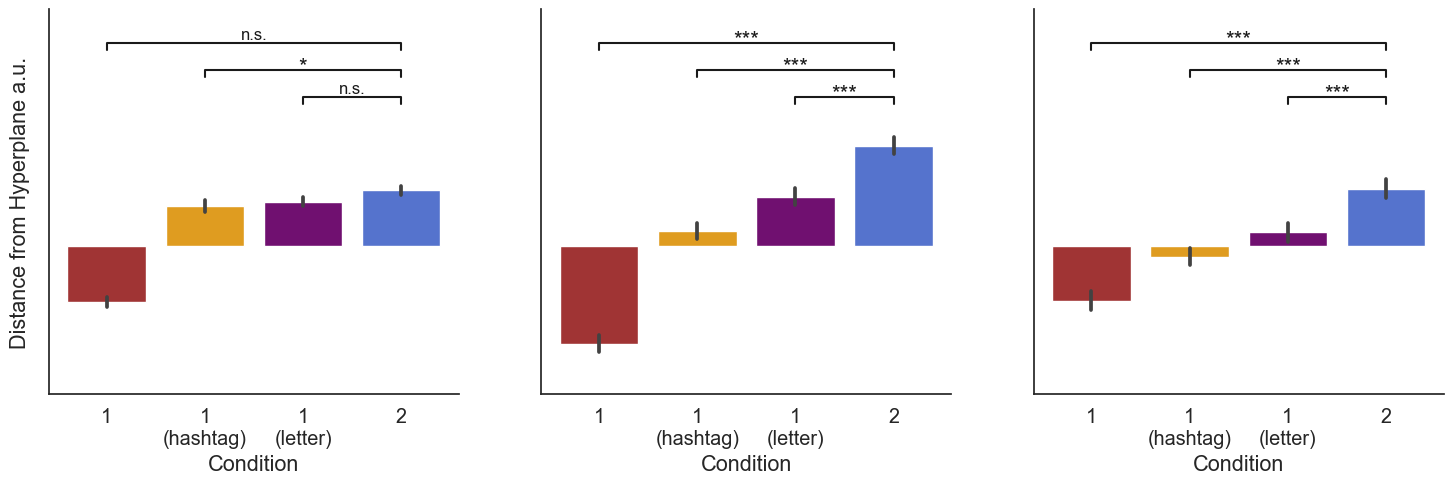

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(font_scale=1.3,style='white',rc=custom_params)

fig,ax = plt.subplots(1,3,figsize=(18,5),sharey=True)

### Stim
# ax[0].axhline(y=0, color='grey', linestyle='-',zorder=-10)
sns.barplot(
    x='Condition',y='Distance from Hyperplane', 
    data=x_0,ax=ax[0],palette= interp.colors[:4],
    dodge=True,errorbar='se')
ax[0].set_ylabel('Distance from Hyperplane a.u.')
ax[0].set_yticklabels([])

stat_y,stat_h = 2.9, .1
ax[0].plot([0, 0, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[0].text(1.5, stat_y+stat_h+.014, 'n.s.', ha='center', va='bottom', color='k', fontsize=12)

stat_y,stat_h = 2.5, .1
ax[0].plot([1, 1, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[0].text(2, stat_y+stat_h-.1, '*', ha='center', va='bottom', color='k', fontsize=16)

stat_y,stat_h = 2.1, .1
ax[0].plot([2, 2, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[0].text(2.5, stat_y+stat_h+.014, 'n.s.', ha='center', va='bottom', color='k', fontsize=12)

### First half
sns.barplot(
    x='Condition',y='Distance from Hyperplane', 
    data=x_1,ax=ax[1],palette= interp.colors[:4],
    dodge=True,errorbar='se')
ax[1].set_ylabel('')

stat_y,stat_h = 2.9, .1
ax[1].plot([0, 0, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[1].text(1.5, stat_y+stat_h-.1, '***', ha='center', va='bottom', color='k', fontsize=16)

stat_y,stat_h = 2.5, .1
ax[1].plot([1, 1, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[1].text(2, stat_y+stat_h-.1, '***', ha='center', va='bottom', color='k', fontsize=16)

stat_y,stat_h = 2.1, .1
ax[1].plot([2, 2, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[1].text(2.5, stat_y+stat_h-.1, '***', ha='center', va='bottom', color='k', fontsize=16)

### Second half
sns.barplot(
    x='Condition',y='Distance from Hyperplane', 
    data=x_2,ax=ax[2],palette= interp.colors[:4],
    dodge=True,errorbar='se')
ax[2].set_ylabel('')

stat_y,stat_h = 2.9, .1
ax[2].plot([0, 0, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[2].text(1.5, stat_y+stat_h-.1, '***', ha='center', va='bottom', color='k', fontsize=16)

stat_y,stat_h = 2.5, .1
ax[2].plot([1, 1, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[2].text(2, stat_y+stat_h-.1, '***', ha='center', va='bottom', color='k', fontsize=16)

stat_y,stat_h = 2.1, .1
ax[2].plot([2, 2, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[2].text(2.5, stat_y+stat_h-.1, '***', ha='center', va='bottom', color='k', fontsize=16)

for a in ax:
    a.set_ylim(-2.2,3.5)
    a.set_xticklabels(['1','1\n(hashtag)','1\n(letter)','2'])

# plt.savefig('output/figures/hyperplane_bar.png',dpi=500,bbox_inches='tight')
# plt.savefig('output/figures/hyperplane_bar.pdf',dpi=500,bbox_inches='tight')
plt.show()

In [9]:
x_0['window'] = 'stim'
x_1['window'] = 'first_half'
x_2['window'] = 'second_half'
all_windows = pd.concat([x_0,x_1,x_2])

In [10]:
all_windows.groupby(['window','Condition']).agg(['mean','std'])['Distance from Hyperplane']

mean       std
window      Condition                      
first_half  1           -1.451533  0.602975
            1 (hashtag)  0.217147  0.568935
            1 (letter)   0.727225  0.606475
            Set size 2   1.480492  0.586893
second_half 1           -0.814285  0.681008
            1 (hashtag) -0.164098  0.604438
            1 (letter)   0.195251  0.652428
            Set size 2   0.841184  0.668731
stim        1           -0.836305  0.333160
            1 (hashtag)  0.581276  0.417481
            1 (letter)   0.647386  0.310836
            Set size 2   0.819239  0.321254

In [11]:
import pingouin
def grab_cond_and_window(cond, window):
    return all_windows.query(f'window=="{window}" & Condition=="{cond}"')['Distance from Hyperplane']

In [13]:
all_windows.Condition.unique()

array(['1', '1 (hashtag)', '1 (letter)', 'Set size 2'], dtype=object)

# different from 2

In [18]:
# STIM
pd.concat([pingouin.ttest(grab_cond_and_window("1", "stim"),grab_cond_and_window("Set size 2", "stim"),paired=True),
pingouin.ttest(grab_cond_and_window("1 (hashtag)", "stim"),grab_cond_and_window("Set size 2", "stim"),paired=True),
pingouin.ttest(grab_cond_and_window("1 (letter)", "stim"),grab_cond_and_window("Set size 2", "stim"),paired=True)])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-11.933791,21,two-sided,8.063287e-11,"[-1.94, -1.37]",5.058788,1.158e+08,1.000000
T-test,-2.447946,21,two-sided,2.324165e-02,"[-0.44, -0.04]",0.638848,2.479,0.815163
T-test,-1.919758,21,two-sided,6.857665e-02,"[-0.36, 0.01]",0.543686,1.05,0.681638


In [23]:
# first_half
pd.concat([pingouin.ttest(grab_cond_and_window("1", "first_half"),grab_cond_and_window("Set size 2", "first_half"),paired=True),
pingouin.ttest(grab_cond_and_window("1 (hashtag)", "first_half"),grab_cond_and_window("Set size 2", "first_half"),paired=True),
pingouin.ttest(grab_cond_and_window("1 (letter)", "first_half"),grab_cond_and_window("Set size 2", "first_half"),paired=True)])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-11.580966,21,two-sided,1.398506e-10,"[-3.46, -2.41]",4.927869,6.902e+07,1.00000
T-test,-6.226699,21,two-sided,3.548256e-06,"[-1.69, -0.84]",2.185779,5622.786,1.00000
T-test,-4.176733,21,two-sided,4.258166e-04,"[-1.13, -0.38]",1.262252,75.747,0.99988


In [24]:
#second half 
pd.concat([pingouin.ttest(grab_cond_and_window("1", "second_half"),grab_cond_and_window("Set size 2", "second_half"),paired=True),
pingouin.ttest(grab_cond_and_window("1 (hashtag)", "second_half"),grab_cond_and_window("Set size 2", "second_half"),paired=True),
pingouin.ttest(grab_cond_and_window("1 (letter)", "second_half"),grab_cond_and_window("Set size 2", "second_half"),paired=True)])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.767490,21,two-sided,0.000010,"[-2.25, -1.06]",2.452920,2181.096,1.000000
T-test,-4.465965,21,two-sided,0.000213,"[-1.47, -0.54]",1.577171,139.719,1.000000
T-test,-2.930455,21,two-sided,0.007993,"[-1.1, -0.19]",0.977753,6.005,0.991976
